# Crossentropy method

This notebook will teach you to solve reinforcement learning with crossentropy method.

In [1]:
import gym
import numpy as np
import pandas as pd

env = gym.make("Taxi-v2")
env.reset()
env.render()

[2017-01-30 19:13:01,480] Making new env: Taxi-v2


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [69]:
policy = np.array([1 / n_actions * np.ones(n_actions)] * n_states)

In [70]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1. / n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [71]:
def generate_session(t_max=10**4):
    """
    Play game until end or for t_max ticks.
    returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):

        # <pick action from policy (at random with probabilities)>
        a = np.random.choice(n_actions, p=policy[s, :])

        new_s, r, done, info = env.step(a)

        # <record prev state, action and add up reward to states,actions and total_reward accordingly>

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [72]:
s, a, r = generate_session()
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) is float

# Training loop
Generate sessions, select N best and fit to those.

In [74]:
n_samples = 250  # sample this many samples
percentile = 50  # take this percent of session with highest rewards
smoothing = 0.1  # add this thing to all counts for stability

for i in range(100):

    # <generate n_samples sessions>
    %time sessions = [generate_session() for i in range(n_samples)]

    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))

    # batch_states: a list of lists of states in each session
    # batch_actions: a list of lists of actions in each session
    # batch_rewards: a list of floats - total rewards at each session

    # <select percentile of your samples>
    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    # <select states from sessions where rewards are above threshold>
    elite_actions = batch_actions[batch_rewards > threshold]
    # <select actions from sessions where rewards are above threshold>

    elite_states, elite_actions = map(
        np.concatenate, [elite_states, elite_actions])
    # hint on task above: use np.percentile and numpy-style indexing

    # count actions from elite states
    elite_counts = np.zeros_like(policy) + smoothing

    # <count all state-action occurences in elite_states and elite_actions>
    for j in range(len(elite_states)):
        elite_counts[elite_states[j], elite_actions[j]] += 1

    policy = elite_counts / elite_counts.sum(axis=1, keepdims=True)
    # <normalize over each state to get probabilities>

    print("mean reward = %.5f\tthreshold = %.1f" %
          (np.mean(batch_rewards), threshold))

CPU times: user 738 ms, sys: 43 ms, total: 781 ms
Wall time: 827 ms
mean reward = -85.24000	threshold = -1653.0
CPU times: user 780 ms, sys: 94.8 ms, total: 875 ms
Wall time: 811 ms
mean reward = -105.50400	threshold = -1966.0
CPU times: user 766 ms, sys: 141 ms, total: 907 ms
Wall time: 810 ms
mean reward = -87.98800	threshold = -1199.0
CPU times: user 691 ms, sys: 133 ms, total: 824 ms
Wall time: 729 ms
mean reward = -75.66000	threshold = -744.0
CPU times: user 713 ms, sys: 114 ms, total: 827 ms
Wall time: 748 ms
mean reward = -77.39600	threshold = -2048.0
CPU times: user 701 ms, sys: 65.4 ms, total: 766 ms
Wall time: 726 ms
mean reward = -78.85600	threshold = -777.0
CPU times: user 714 ms, sys: 70.1 ms, total: 784 ms
Wall time: 757 ms
mean reward = -80.67200	threshold = -1269.0
CPU times: user 686 ms, sys: 16.2 ms, total: 702 ms
Wall time: 982 ms
mean reward = -70.46400	threshold = -1438.0
CPU times: user 677 ms, sys: 15.8 ms, total: 693 ms
Wall time: 856 ms
mean reward = -66.03600	

KeyboardInterrupt: 

# Approximate (deep) crossentropy method

In this section we will train a neural network policy for continuous action space game

[2017-01-30 20:10:57,298] Making new env: CartPole-v0


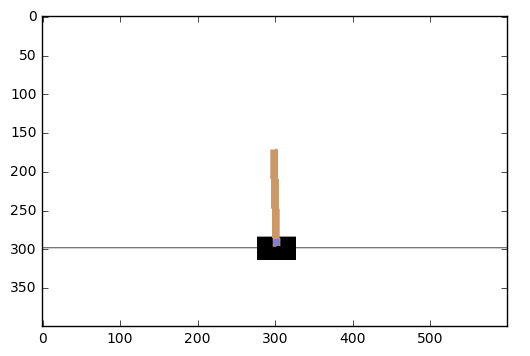

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))

In [85]:
# create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='tanh',
                      warm_start=True,  # keep progress between .fit(...) calls
                      max_iter=1  # make only 1 iteration on each .fit(...)
                      )
# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions, range(n_actions))

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [86]:
def generate_session(t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent.predict_proba([s])[0]

        # <sample action with such probabilities>
        a = np.random.choice(n_actions, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [87]:
n_samples = 100
percentile = 70
smoothing = 0.01

for i in range(100):
    # generate new sessions
    sessions = [generate_session() for _ in range(n_samples)]

    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))
    # batch_states: a list of lists of states in each session
    # batch_actions: a list of lists of actions in each session
    # batch_rewards: a list of floats - total rewards at each session

    # <select percentile of your samples>
    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    # <select states from sessions where rewards are above threshold>
    elite_actions = batch_actions[batch_rewards > threshold]

    elite_states, elite_actions = map(
        np.concatenate, [elite_states, elite_actions])
    # elite_states: a list of states from top games
    # elite_actions: a list of actions from top games

    # <fit agent to predict elite_actions(y) from elite_states(X)>
    agent.fit(elite_states, elite_actions)

    print("mean reward = %.5f\tthreshold = %.1f" %
          (np.mean(batch_rewards), threshold))

mean reward = 22.44000	threshold = 22.0
mean reward = 21.68000	threshold = 24.0
mean reward = 28.71000	threshold = 31.3
mean reward = 29.75000	threshold = 35.9
mean reward = 33.75000	threshold = 38.3
mean reward = 37.94000	threshold = 46.3
mean reward = 44.40000	threshold = 54.0
mean reward = 42.33000	threshold = 53.0
mean reward = 49.11000	threshold = 54.6
mean reward = 50.81000	threshold = 61.6
mean reward = 56.09000	threshold = 66.0
mean reward = 65.24000	threshold = 80.3
mean reward = 62.42000	threshold = 76.3
mean reward = 63.42000	threshold = 70.0
mean reward = 70.20000	threshold = 86.0
mean reward = 72.13000	threshold = 82.0
mean reward = 88.02000	threshold = 105.0
mean reward = 89.14000	threshold = 98.3
mean reward = 103.61000	threshold = 129.3
mean reward = 114.95000	threshold = 134.6
mean reward = 114.80000	threshold = 124.6
mean reward = 130.18000	threshold = 145.0
mean reward = 134.12000	threshold = 154.3
mean reward = 164.68000	threshold = 181.3
mean reward = 175.85000	thr

KeyboardInterrupt: 

# Results

In [88]:
# finish recording
import gym.wrappers
env = gym.wrappers.Monitor(env, directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
# unwrap
env = env.env.env
# upload to gym
# gym.upload("./videos/",api_key="<your_api_key>")

[2017-01-30 20:15:59,859] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-01-30 20:15:59,863] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-01-30 20:15:59,870] Starting new video recorder writing to /Users/libfun/Development/Practical_RL/week1/videos/openaigym.video.1.34349.video000000.mp4
[2017-01-30 20:16:03,227] Starting new video recorder writing to /Users/libfun/Development/Practical_RL/week1/videos/openaigym.video.1.34349.video000001.mp4
[2017-01-30 20:16:06,517] Starting new video recorder writing to /Users/libfun/Development/Practical_RL/week1/videos/openaigym.video.1.34349.video000008.mp4
[2017-01-30 20:16:10,530] Starting new video recorder writing to /Users/libfun/Development/Practical_RL/week1/videos/openaigym.video.1.34349.video0000

In [89]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + video_names[-1]))  # this may or may not be _last_ video. Try other indices

# Challenge

Now try to solve LunarLander-v2 or MountainCar-v0

In [1]:
import gym
import numpy as np
import pandas as pd

env = gym.make("LunarLander-v2")
env.reset()
# env.render()

[2017-02-02 10:14:25,807] Making new env: LunarLander-v2


array([-0.00450888,  0.93701373, -0.45672774, -0.23999281,  0.00523156,
        0.1034556 ,  0.        ,  0.        ])

In [2]:
n_actions = env.action_space.n

print(" n_actions=%i" % (n_actions))

 n_actions=4


In [4]:
# create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(64, 64, 64),
                      activation='relu',
                      warm_start=True,  # keep progress between .fit(...) calls
                      max_iter=1  # make only 1 iteration on each .fit(...)
                      )
# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions, range(n_actions))

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(64, 64, 64), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

In [5]:
def generate_session(t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        # predict array of action probabilities
        probs = agent.predict_proba([s])[0]

        # <sample action with such probabilities>
        a = np.random.choice(n_actions, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [6]:
n_samples = 250
percentile = 70
smoothing = 0.01

for i in range(30):
    # generate new sessions
    sessions = [generate_session() for _ in range(n_samples)]

    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))
    # batch_states: a list of lists of states in each session
    # batch_actions: a list of lists of actions in each session
    # batch_rewards: a list of floats - total rewards at each session

    # <select percentile of your samples>
    threshold = np.percentile(batch_rewards, percentile)
    elite_states = batch_states[batch_rewards > threshold]
    # <select states from sessions where rewards are above threshold>
    elite_actions = batch_actions[batch_rewards > threshold]

    elite_states, elite_actions = map(
        np.concatenate, [elite_states, elite_actions])
    # elite_states: a list of states from top games
    # elite_actions: a list of actions from top games

    # <fit agent to predict elite_actions(y) from elite_states(X)>
    agent.fit(elite_states, elite_actions)

    print("mean reward = %.5f\tthreshold = %.1f" %
          (np.mean(batch_rewards), threshold))

mean reward = -226.17105	threshold = -145.9
mean reward = -225.99352	threshold = -149.4
mean reward = -202.86022	threshold = -149.1
mean reward = -191.35027	threshold = -137.4
mean reward = -176.28996	threshold = -129.8
mean reward = -167.29097	threshold = -132.9
mean reward = -163.70057	threshold = -124.1
mean reward = -151.74667	threshold = -123.5
mean reward = -140.25158	threshold = -115.8
mean reward = -135.26976	threshold = -108.0
mean reward = -119.03713	threshold = -93.4
mean reward = -106.38572	threshold = -90.3
mean reward = -93.72573	threshold = -74.9
mean reward = -84.15441	threshold = -64.4
mean reward = -78.20060	threshold = -58.2
mean reward = -68.47193	threshold = -53.2
mean reward = -60.62352	threshold = -46.8
mean reward = -54.13369	threshold = -37.2
mean reward = -47.22817	threshold = -29.2
mean reward = -42.87079	threshold = -25.8
mean reward = -32.51810	threshold = -15.2
mean reward = -22.32220	threshold = -10.3
mean reward = -24.43492	threshold = -3.6
mean reward =

KeyboardInterrupt: 

In [9]:
# finish recording
import gym.wrappers
env = gym.wrappers.Monitor(env, directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()
# unwrap
env = env.env.env
# upload to gym
# gym.upload("./videos/",api_key="<your_api_key>")

[2017-02-02 10:42:38,243] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0


DoubleWrapperError: Attempted to double wrap with Wrapper: TimeLimit

In [ ]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/" + video_names[-1]))  # this may or may not be _last_ video. Try other indices